# Sparkify Capstone Project

### Executive Summary and Business Overview

Sparkify is Udacity's (on paper...so far) music streaming service, that produces data similar to Spotify or Pandora. User play and/or rate their favorite songs through such services on a daily basis. The business model employed is a free and pay tiered system where free/unpaid users have generally limited access and often using advertisements to offset the royalty fees paid to music artists. Users have the ability to upgrade their service (become a paying customer), or downgrade their service (from paying to non-paying); both tiers have the ability to cancel their service, and that lost of a customer would be considered "customer churn".

All user interaction with Sparkify revolves around these activities:

* Play a song 
* Creating and updating playlists
* Rating song with the thumbs up or thumbs down button
* Add a friend
* Logging in or out
* Changing settings

Each of these activites generates an entry into the user logs. Naturally, log analytics are a key factor for the Sparkify marketing team and all the executive staff.

### Project Objectives

* gain insight into the data 
* understand who is churning 
* what is driving that churn.

## Sparkify Overview

<p>This is my Capstone project, I'll be using Spark to analyze data from user log files from music app Sparkify.</p>

<p>Sparkify is a freeware/payware music app, similar to Pandora or Spotify.  The data we will analyze have contains Sparkify user logs that contain user interaction with the app. The log contains some basic user information as well as essentially click-thru information. Our user community consists of 

* Guests
* Free/non-paying customers
* Paying customer</p>

<p>Our mission is to review and wrangle the data and engineer relevant features for predicting churn. Churn for us means either a Free or Paying customer cancels their service. </p>


In [1]:
# import libraries

from pyspark.sql import SparkSession

from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, count, isnan, when, isnull, collect_list,udf,countDistinct
from pyspark.sql.types import IntegerType, DateType

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.sql import Window
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import time 

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

In [3]:
from platform import python_version
print(python_version())

3.7.6


In [4]:
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
df = spark.read.json("data/mini_sparkify_event_data.json")
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [6]:
df.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [7]:
# I moved this up top to show all values of the "auth" field. When I drop the null registrations, "guest"
# and "logged out" will also be dropped

df.select('auth').dropDuplicates().show()

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+



In [8]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [9]:
# How many records and columns?
print("(Number of Records, Number of columns):",((df.count(), len(df.columns))))

(Number of Records, Number of columns): (286500, 18)


In [10]:
# Let's count the number of nulls across the record
# I'm mostly interested in the registration field first, since that is when we first saw a user
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [11]:
# This is a little easier to read

print("Columns with Null Values")
for colName, dtype in df.dtypes:
    print(colName,':', df.filter(df[colName].isNull()).count())

Columns with Null Values
artist : 58392
auth : 0
firstName : 8346
gender : 8346
itemInSession : 0
lastName : 8346
length : 58392
level : 0
location : 8346
method : 0
page : 0
registration : 8346
sessionId : 0
song : 58392
status : 0
ts : 0
userAgent : 8346
userId : 0


#### Missing Values

We can see userAgent, registration, firstName, lastName, location and gender are all have missing values. I'm thinking we should drop those records, let's calculate the percentage.

In [12]:
# Percentage Check
total = float(df.count())
missing = float(df.filter(df.registration.isNull()).count())
percentage = missing *100.0 /total

In [13]:
print('Total Records:', total)
print('Missing Registration:', missing)
print('Percentage of Missing Registration:', percentage)

Total Records: 286500.0
Missing Registration: 8346.0
Percentage of Missing Registration: 2.913089005235602


So less than 3%, so we can drop those records.

In [14]:
# The ever powerful filter. Sort of feel like it needs an "are you sure(y/n)?" option
# https://sparkbyexamples.com/pyspark/pyspark-dataframe-filter/

df_clean = df.filter(df.registration.isNotNull())

In [15]:
# Removed the Missing Registration records
df_clean.count()

278154

In [16]:
# Percentage Check on cleaned 
total = float(df_clean.count())
missing = float(df_clean.filter(df_clean.registration.isNull()).count())
percentage = missing *100.0 /total

In [17]:
# Safety check
print('Total Records:', total)
print('Missing Registration:', missing)
print('Percentage of Missing Registration:', percentage)

Total Records: 278154.0
Missing Registration: 0.0
Percentage of Missing Registration: 0.0


In [18]:
# df now has removed rows
df = df_clean

In [19]:
df.count()

278154

In [20]:
# Check for empty string in UserID. Wanted to make sure we have records that all have user ID. For this study,
# these are the only users we are interested in
# We can see no nulls or empty strings.
df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
|100018|
+------+
only showing top 20 rows



In [21]:
# Secondary null check for UID, confirming no nulls
missing_uid = float(df.filter(df.userId.isNull()).count())
print('missing UID:',missing_uid)

missing UID: 0.0


In [22]:
# These are the fields left to
df.toPandas().info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278154 entries, 0 to 278153
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   artist         228108 non-null  object 
 1   auth           278154 non-null  object 
 2   firstName      278154 non-null  object 
 3   gender         278154 non-null  object 
 4   itemInSession  278154 non-null  int64  
 5   lastName       278154 non-null  object 
 6   length         228108 non-null  float64
 7   level          278154 non-null  object 
 8   location       278154 non-null  object 
 9   method         278154 non-null  object 
 10  page           278154 non-null  object 
 11  registration   278154 non-null  int64  
 12  sessionId      278154 non-null  int64  
 13  song           228108 non-null  object 
 14  status         278154 non-null  int64  
 15  ts             278154 non-null  int64  
 16  userAgent      278154 non-null  object 
 17  userId         278154 non-nul

In [23]:
df.select('gender').dropDuplicates().show()

+------+
|gender|
+------+
|     F|
|     M|
+------+



In [24]:
# Level indicates a paid or free user
df.select('level').dropDuplicates().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [25]:
# HTTP Methods
df.select('method').dropDuplicates().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [26]:
# Page types
df.select('page').dropDuplicates().show()
print("Number of page types:", df.select('page').dropDuplicates().count())

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+

Number of page types: 19


In [27]:
# Believe this is the code from an HTTP page
df.select('status').dropDuplicates().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [28]:
# As mentioned earlier, "guest" and "logged out" were dropped along with null registrations
df.select('auth').dropDuplicates().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [29]:
df.select('userAgent').dropDuplicates().show()
print ("Number of User Agents: ", df.select('userAgent').dropDuplicates().count())

+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (X11;...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|Mozilla/5.0 (Maci...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Maci...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (iPh...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
+--------------------+
only showing top 20 rows

Number of User Agents:  56


In [30]:
# Further refinement

# I've left this in, since it's part of cleaning AND understanding the data. First pass through, I decided
# to drop the records where "registration" was null. It turns out that also dropped out the "Guest" and
# "Logged Out" field. So, the filter below was NOT needed. However, this also shows the iterative nature
# of data understanding. 

# For production code, I would drop this cell. Left in as illustration

# We don't need either Guest or Logged Out records, since there is no churn associated with them. As well, 
# neither field would have a UserID
df = df.filter((df.auth != 'Guest') & (df.auth != 'Logged Out'))
df.select('auth').dropDuplicates().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [31]:
# Review a free user usage
df.filter(df["userId"] == "32").show(10)

+--------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          RJD2|Logged In|    Diego|     M|            0|   Mckee|237.53098| free|Phoenix-Mesa-Scot...|   PUT|       NextSong|1537167593000|      218|Beyond The Beyond...|   200|1538578897000|"Mozilla/5.0 (iPh...|    32|
| Guns N' Roses|Logged In|    Diego|     M|            1|   Mckee|406.17751| free|Phoenix-Mesa-Scot...|   PUT|      

In [32]:
# Review a paid user
df.filter(df["userId"] == "20").show(10)

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+
|                null|Logged In|  Destiny|     F|            0| Herring|     null| paid|Miami-Fort Lauder...|   GET|     Home|1536844410000|      216|                null|   200|1538529207000|"Mozilla/5.0 (Win...|    20|
|Bob Marley & The ...|Logged In|  Destiny|     F|            1| Herring|210.33751| paid|Miami-Fort Lauder...|   PUT|

#### Data Findings


This is my intial set of findings about the dataset. Since the documentation about the log records was not present, potentially this would be updated as more is known about the dataset.

This also presents a minor quandary. What fields/features should I drop, if any, for the upcoming models. In other binary classification problems I've worked on at my job, we tend to leave more in. Especially when there is little to nothing known about the dataset. At present, there are 18 columns. There are potentially a few "easy" ones to drop. For example, I could drop the first and last name. I doubt they will be a very important feature. However, being more inclusive than less is the direction I'm going. 

Here's what has been surmised around a user:
* User Id : User identifier 
* firstName: Users first name
* lastName: Users surname
* gender: either M or F
* location: not known if this comes from the IP address or user provided. Leaning towards from the IP address
* userAgent:  OS/method used to access Sparkify. (57 different categories)
* registration: UNIX/epoch time stamp for presume initial registration
* level: user subscription status (free or paid)

Log details:

* ts : timestamp of a given log  
* page : type of page access (22 categories) 
* auth : authentication status (4 categories) 
* sessionID : what session for the log
* itemInSession : a counter maintained for what looks like a given session
* method : http method
* status : looks like the http status code;

Song details
* song : song name
* artist : artist name
* length: song's length (seconds)


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [33]:
#Review: Cancellation Confirmation is an element of "page"

df.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [34]:
# Wanted to use an RDD, but not much covered in the lectures. Came across this:
# Initially thought rdd.map() would work, but went with rdd.flatmap() after reading this:
# https://www.tutorialkart.com/apache-spark/spark-rdd-map-java-python-examples/
# Initially was interested in RDD's since that was the lesson where python vs. SQL was explored. That was one 
# area that I was trying to sort out the difference. Not much SQL in this exercise, but worth exploring later
# down the road in some depth since I do a lot of SQL

# Did we see cancellation confirmation? If so, they have churn and we will assign a 1, otherwise a 0
# Having a binary value makes a variety of analysis easier

churn_users = df.filter(df.page == 'Cancellation Confirmation')\
                                            .select('userId')\
                                            .dropDuplicates()\
                                            .rdd.flatMap(lambda x : x)\
                                            .collect()

In [35]:
# Add in churn column
df = df.withColumn('churn', when(col("userId").isin(churn_users), 1).otherwise(0))

In [36]:
# Check churn column present
dfp = df.toPandas()
dfp.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0


#### Churn Defined

* 1 - users who cancelled their subscription within the observation period
* 0 - users who kept the service throughout


In [37]:
# Unique churn
# Will add more visualization, just want to get a quick check
# 173 users kept service
# 52 users churned

# Here's an interesting conundrum. How to be convey/display the values around Churn. For our purposes of 
# picking features and model development, I set a value of 0 and 1 to indicate not/did churn. Fine for those functions
# where numeric values are useful/required, that's great. 
# However, this is why I find visualization helpful. I can be more descriptive in the visualization that 
# a raw number display like below. 
# Yes, I could have added yet another column, something like "yes/no" to indicate churn, or do some sort of 
# transformation prior to printing. But for me, I lean toward visualizations 

dfp.drop_duplicates(subset='userId').groupby(['churn'])['userId'].count()

churn
0    173
1     52
Name: userId, dtype: int64

In [38]:
# Use a temporary DataFrame to do some Pandas specific EDA
temp_df = df.toPandas()

#### EDA Visualizations

In general, I do most of my EDA visually. Possibly since I use a variety of data quality tools at work that have a lot of data wrangling capabilities, but here are a set that I used to further explore the dataset

#### Battle of the visualizations

I've used both Seaborn and Matplotlib here. I tend more towards using Matplotlib these days, since it conveys information both visually and quickly. My experience with Seaborn, while generally favorable, is that I spend more time that likely is necessary to create something that is visually "eye-candy", but in the end conveys the same information as Matplotlib. 



#### Spark Programming
 
While the lectures and example programs were helpful, I found these references helpful. I found that "drop_duplicates" was a pretty handy function, below is some more detail on that I found helpful.

Helpful spark info: https://sparkbyexamples.com/spark/spark-remove-duplicate-rows/

And of course the reference info: http://spark.apache.org/docs/2.3.0/api/python/pyspark.sql.html

All of that said, first EDA check shows that more customer stay active than churn. A good piece of information. However...that number of churned customers is I'm sure higher than anyone wants to see. So, having a plan in place and ML that helps minimize this number can only be a good thing for Sparkify.

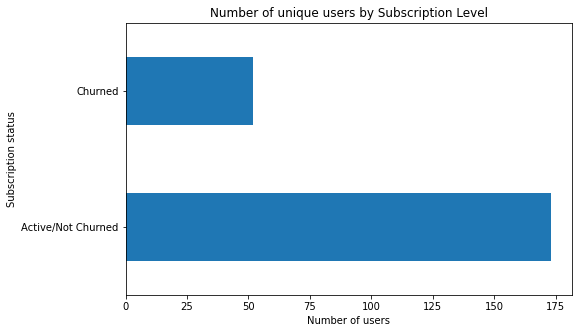

In [39]:
# Visualize the users churned
ax = temp_df.drop_duplicates(subset='userId').groupby('churn')['userId'].count().plot(
                                kind='barh', figsize=(8,5), 
                                title='Number of unique users by Subscription Level');
ax.set_xlabel('Number of users');
ax.set_yticklabels(['Active/Not Churned', 'Churned'], rotation=0)
ax.set_ylabel("Subscription status");

# Test    
#plot_frequency(['userId'], ['churn'], ['Active', 'Cancelled'])

Note: For ease of reading, I will refer to Not Churned users as Active now

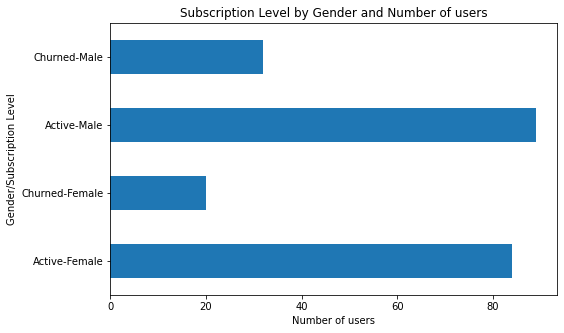

In [40]:
# Churn by visualization of gender

df_gen = df.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
ax = temp_df.drop_duplicates(subset=['userId', 'gender']).groupby(['gender', 'churn'])['userId'].count().plot(
                                kind='barh', figsize=(8,5), 
                                title='Subscription Level by Gender and Number of users');
ax.set_xlabel('Number of users');
ax.set_yticklabels(['Active-Female', 'Churned-Female', 'Active-Male', 'Churned-Male'], rotation=0)
ax.set_ylabel("Gender/Subscription Level");

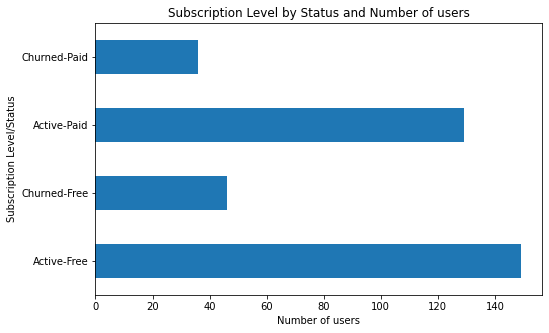

In [41]:
# Visualize by churn and subscription 
ax = temp_df.drop_duplicates(subset=['userId', 'level']).groupby(['level', 'churn'])['userId'].count().plot(
                                kind='barh', figsize=(8,5), 
                                title='Subscription Level by Status and Number of users');
ax.set_xlabel('Number of users');
ax.set_yticklabels(['Active-Free', 'Churned-Free', 'Active-Paid', 'Churned-Paid'], rotation=0)
ax.set_ylabel("Subscription Level/Status");

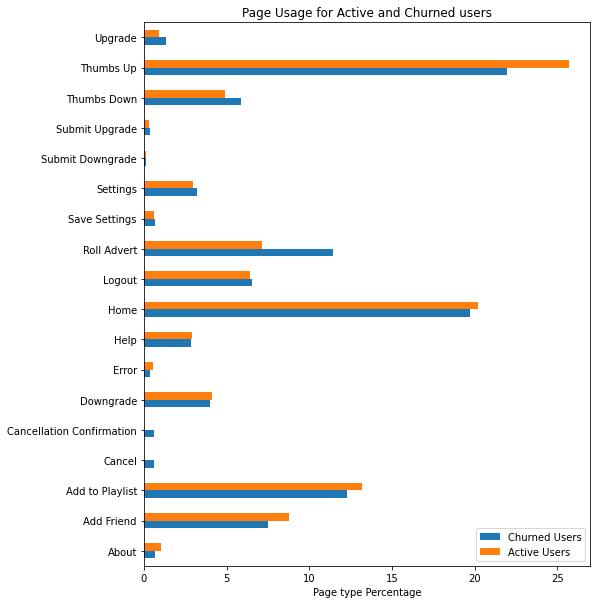

In [42]:
# Page Analysis 
# I used percentage as a comparison, otherwise the bar length is too small
users_1 = dfp[dfp.churn == 1].groupby(['page'])['userId'].count().drop('NextSong')
users_1 = users_1 /users_1.sum()*100

users_0 = dfp[dfp.churn == 0].groupby(['page'])['userId'].count().drop('NextSong')
users_0 = users_0 /users_0.sum()*100

users_df = pd.DataFrame({'Churned Users': users_1,'Active Users':users_0})
ax = users_df.plot(kind='barh', figsize=(8,10));
ax.set_xlabel('Page type Percentage')
ax.set_title('Page Usage for Active and Churned users');



In [43]:
#Time for a little Spark SQL. I need to create a temp SQL view

df.createOrReplaceTempView("sql_view_table")


In [44]:
number_of_sessions = spark.sql("SELECT userId, avg(count) as average from (SELECT userId, count(*) as count FROM sql_view_table group by sessionId, userId) group by userId")

In [45]:
churned_users = list(dfp[dfp['page'] == 'Cancellation Confirmation']['userId'].unique())

In [46]:
churned_users.sort()

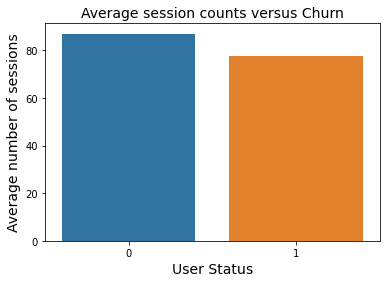

In [47]:
pd_num_sessions = number_of_sessions.toPandas()
pd_num_sessions['churn'] = pd_num_sessions['userId'].apply(lambda x: 1 if x in churned_users else 0)
sns.barplot(x="churn", y="average", data=pd_num_sessions, ci=None);
plt.xlabel("User Status", fontsize=14);
plt.ylabel("Average number of sessions", fontsize=14);
plt.title("Average session counts versus Churn", fontsize=14);

#### Notes from EDA

1) We have more customers staying active than churning.

2) Believe that the churn rate is still too high.

3) Males both churn or stay active at a higher rate than females.

4) The free users both churn or stay active at a higher rate than the pay users.

5) Page analysis shows that the ratings system (thumbs up/down) is popular.

6) This is followed by adding to a playlist and adding a friend.

7) Session count is higher for the active customers, although the churn customers have a faily high amount as well.



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

After analyzing all the column above i have decided to use below features in my model:

* Gender<br/>
* UserAgent<br/>
* Status<br/>
* Page<br/>

<p>Once the columns were identified, we now have to make sure that they are all numeric datatypes for ML use. The Gender, UserAgent and Ppage columns will be converted into numeric values using a combination of String Indexing and One Hot encoding.</p>



#### Helpful Extract and Transform links

https://spark.apache.org/docs/2.4.3/ml-features.html
    
Super helpful guide here: https://towardsdatascience.com/feature-encoding-with-spark-2-3-0-part-1-9ede45562740

Part 2 was good too: https://towardsdatascience.com/feature-encoding-made-simple-with-spark-2-3-0-part-2-5bfc869a809a

        

In [48]:
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId',
 'churn']

In [49]:
# Set up the Indexers and Encoders for the Vector Assembler. 
# Refererences for StringIndexer and OneHotEncoder: https://spark.apache.org/docs/2.3.0/ml-features.html
# stages variable needed later for the Pipeline

cols = df.columns
stages = []
Gender_indexer = StringIndexer(inputCol="gender", outputCol='Gender_Index')
User_indexer = StringIndexer(inputCol="userAgent", outputCol='User_Index')
Page_indexer = StringIndexer(inputCol="page", outputCol='Page_Index')


Gender_encoder = OneHotEncoder(inputCol='Gender_Index', outputCol='Gender_Vec')
User_encoder = OneHotEncoder(inputCol='User_Index', outputCol='User_Vec')
Page_encoder = OneHotEncoder(inputCol='Page_Index', outputCol='Page_Vec')

stages += [Gender_indexer, Gender_encoder]
stages += [User_indexer, User_encoder]
stages += [Page_indexer, Page_encoder]

# Get single vector column for our binary classification models
assembler = VectorAssembler(inputCols=["Gender_Vec", "User_Vec", "Page_Vec", "status"], outputCol="features")
#assembler = VectorAssembler(inputCols=["Gender_Vec", "User_Vec", "Page_Vec", "status"])
stages += [assembler]

# I define indexer as the binary field to be determined (Churn = yes or no?)
indexer = StringIndexer(inputCol="churn", outputCol="label")
#indexer = StringIndexer(inputCol="churn")
stages += [indexer]

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

##### Model choices

We have a simple but key business need here. Answer the binary yes or no question: "Will a customer churn?". This represents a dynamic on two important fronts:

1) How can we keep existing customers from churning
2) How can we prevent future customer from churning

There is also a another key question that would require potentially more data and analysis which is "How can we get free customers to become paid customers?". As they saying goes, that is beyond the scope of this exericse. However, that would be my next step. 

Back to the question at hand, how to prevent churn. I've chosen two good classification models to use for this exercise:

* Logistic regression
* Random Forest 


#### Some references

https://spark.apache.org/docs/2.4.3/ml-classification-regression.html

https://www.analyticsvidhya.com/blog/2019/11/build-machine-learning-pipelines-pyspark/

https://spark.apache.org/docs/2.4.3/ml-pipeline.html

https://projector-video-pdf-converter.datacamp.com/14989/chapter4.pdf

https://www.datacamp.com/community/tutorials/apache-spark-tutorial-machine-learning

http://spark.apache.org/docs/2.4.3/ml-tuning.html



#### Pyspark ML statistics

Part of this code comes from the ideas and examples in this great Pyspark/ML article:
https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa

The pipeline in Pyspark ML is a series of stages, one for the Transformer and the other for the Estimator.

The advantage of having ML capabilities in Spark is that most ML libraries are not really "distribued processing" friendly, or have limited pipelining capabilities. 

In [50]:
# Time to build a pipeline to feed into the ML model
# Helpful: Spark pipeline/transformer guide: http://spark.apache.org/docs/2.4.3/ml-pipeline.html

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = false)



In [51]:
selectedCols

['label',
 'features',
 'artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId',
 'churn']

In [52]:
df = df.select(selectedCols)

In [53]:
# We can see the 'label' and 'features' columns are added
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,0,0,0,0,0
features,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
artist,Martha Tilston,Five Iron Frenzy,Adam Lambert,Enigma,Daft Punk
auth,Logged In,Logged In,Logged In,Logged In,Logged In
firstName,Colin,Micah,Colin,Micah,Colin
gender,M,M,M,M,M
itemInSession,50,79,51,80,52
lastName,Freeman,Long,Freeman,Long,Freeman
length,277.89,236.094,282.827,262.713,223.608
level,paid,free,paid,free,paid


In [54]:
# Set up test and training data with the pyspark randomsplit function
# From here: https://spark.apache.org/docs/2.4.3/api/python/pyspark.sql.html
# Use 90% training, 10% test. We've used 42 as the random seed before

test_set, validation = df.randomSplit([0.9, 0.1], seed=42)

#### First Model to Run: Logistic Regression

I'll run a "basic" Logistic Regression against our test dataset. As well, I'll print out a number of metrics that are available from the Pyspark ML Library

Again, want to mention this article on getting metrics from Pyspark ML and it's associated libraries. While the Pyspark documentation is pretty good, it's a bit dense in terms of pulling out information on how to get to the metrics that are easier (or better documented) in Python and Sci-Py. 

https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa



In [55]:
#"Basic" Logistic Regression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)

In [56]:
# Fit the model to the test data
lrModel = lr.fit(test_set)

In [57]:
# Here are the coefficients
# An eye chart, but I put this in to show how to get to them
# This was a helpful guide from the good folks at DataBricks
# https://docs.databricks.com/applications/machine-learning/mllib/binary-classification-mllib-pipelines.html
lrModel.coefficients

DenseVector([-1.4017, 0.9886, 1.4386, 0.3141, -0.3423, 0.1465, -2.2107, 0.6836, 1.2692, -2.8317, -2.6865, 0.7737, 1.7488, -0.4829, 1.5791, 0.4005, 0.673, -2.8722, -3.0057, 1.5967, 2.2499, 0.224, 6.0289, -3.5671, -2.5611, -3.1536, 3.3069, -3.0453, -3.5599, -3.5642, 3.9645, -3.5589, -3.5717, 9.4313, 8.8011, -2.5602, -3.5618, -3.5835, -3.5533, 3.5166, -0.4989, -3.5658, 2.613, -2.6011, -2.5526, 9.4132, -1.7897, -3.6066, -3.4666, -2.5419, -2.5846, -3.5843, -3.6101, -2.6032, -3.6104, 9.3642, -0.094, -0.1691, -0.0474, -0.084, -0.0704, 0.6246, 0.0255, 0.1139, -0.1381, 0.0531, 0.0342, 0.3214, -0.3325, 0.0727, -0.3894, 0.1846, -0.112, 8.7188, -0.0005])

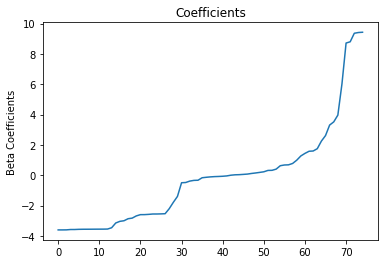

In [58]:
# Here are the Logistic Regression Coefficients
# 
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.title('Coefficients')
plt.ylabel('Beta Coefficients')
plt.show()

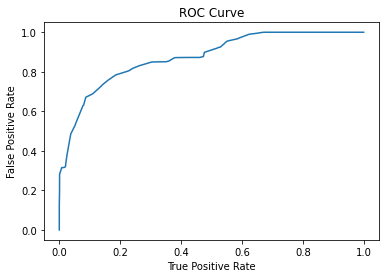

Training set areaUnderROC: 0.8740735904092564


In [59]:
# This is a handy summary 
# From https://spark.apache.org/docs/2.4.3/ml-classification-regression.html#binomial-logistic-regression
# And all the measures: https://spark.apache.org/docs/2.4.3/api/python/pyspark.ml.html#pyspark.ml.classification.LogisticRegressionSummary

trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

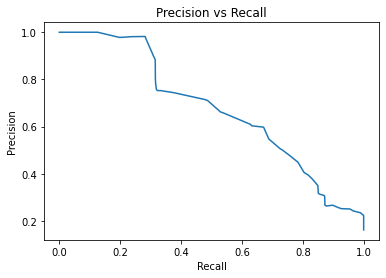

In [60]:
# Precision vs recall 
pr = trainingSummary.pr.toPandas()
plt.title('Precision vs Recall')
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [61]:
# This is a summary of the predictions
predictions = lrModel.transform(test_set)
predictions.select('gender', 'UserAgent', 'page' ,'label', 'rawPrediction', 'prediction', 'probability').show(10)

+------+--------------------+--------+-----+--------------------+----------+--------------------+
|gender|           UserAgent|    page|label|       rawPrediction|prediction|         probability|
+------+--------------------+--------+-----+--------------------+----------+--------------------+
|     F|"Mozilla/5.0 (Win...|NextSong|  0.0|[2.25731866841775...|       0.0|[0.90527996153683...|
|     F|"Mozilla/5.0 (Win...|NextSong|  0.0|[2.25731866841775...|       0.0|[0.90527996153683...|
|     F|"Mozilla/5.0 (Win...|NextSong|  0.0|[2.25731866841775...|       0.0|[0.90527996153683...|
|     F|"Mozilla/5.0 (Win...|NextSong|  0.0|[2.25731866841775...|       0.0|[0.90527996153683...|
|     F|"Mozilla/5.0 (Win...|NextSong|  0.0|[2.25731866841775...|       0.0|[0.90527996153683...|
|     F|"Mozilla/5.0 (Win...|NextSong|  0.0|[2.25731866841775...|       0.0|[0.90527996153683...|
|     F|"Mozilla/5.0 (Win...|NextSong|  0.0|[2.25731866841775...|       0.0|[0.90527996153683...|
|     F|"Mozilla/5.0

In [62]:
# Print out the confusion matrix and the F1 score
# From https://spark.apache.org/docs/2.4.3/api/java/org/apache/spark/ml/evaluation/MulticlassClassificationEvaluator.html#metricName--
cm = MulticlassClassificationEvaluator(metricName = 'f1')
f1_score = cm.evaluate(predictions)
confusion_matrix = (predictions.groupby("label").pivot("prediction").count().toPandas())
print("The F1 Score: ",f1_score)
confusion_matrix

The F1 Score:  0.8511582947715388


,label,0.0,1.0
0,0.0,205800,4116
1,1.0,27529,12890


In [63]:
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8739056785015092


In [64]:
# Reset for next run
# Set up the Indexers and Encoders for the Vector Assembler. 
# Refererences for StringIndexer and OneHotEncoder: https://spark.apache.org/docs/2.4.3/ml-features.html
# stages variable needed later for the Pipeline

stages = []
Gender_indexer = StringIndexer(inputCol="gender", outputCol='Gender_Index')
User_indexer = StringIndexer(inputCol="userAgent", outputCol='User_Index')
Page_indexer = StringIndexer(inputCol="page", outputCol='Page_Index')


Gender_encoder = OneHotEncoder(inputCol='Gender_Index', outputCol='Gender_Vec')
User_encoder = OneHotEncoder(inputCol='User_Index', outputCol='User_Vec')
Page_encoder = OneHotEncoder(inputCol='Page_Index', outputCol='Page_Vec')

stages += [Gender_indexer, Gender_encoder]
stages += [User_indexer, User_encoder]
stages += [Page_indexer, Page_encoder]

# Get single vector column for our binary classification models
#assembler = VectorAssembler(inputCols=["Gender_Vec", "User_Vec", "Page_Vec", "status"], outputCol="features")
assembler = VectorAssembler(inputCols=["Gender_Vec", "User_Vec", "Page_Vec", "status"])
stages += [assembler]

# I define indexer as the binary field to be determined (Churn = yes or no?)
#indexer = StringIndexer(inputCol="churn", outputCol="label")
indexer = StringIndexer(inputCol="churn")
stages += [indexer]

#### Second Model to Run: Random Forest Classifier

This run adds in a pipeline. 

Pipeline docs here: https://spark.apache.org/docs/2.4.3/ml-pipeline.html


In [65]:
rf = RandomForestClassifier(labelCol="label",\
                            featuresCol="features",\
                            featureSubsetStrategy='sqrt')

# creating pipeline
pipeline_rf = Pipeline(stages=[Gender_indexer, User_indexer, Page_indexer, Gender_encoder,
                            User_encoder, Page_encoder, assembler, indexer, lr])

# paramGrid = ParamGridBuilder() \
#     .build()


# building paramgrid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.impurity,['entropy', 'gini']) \
    .addGrid(rf.maxDepth,[2, 4, 6, 8]) \
    .addGrid(rf.numTrees,[10, 25, 50, 100]) \
    .build()

crossval_rf = CrossValidator(estimator=pipeline_rf,\
                             estimatorParamMaps=paramGrid,\
                             evaluator=MulticlassClassificationEvaluator(),\
                             numFolds=3)

cvModel_rf = crossval_rf.fit(test_set)
results = cvModel_rf.transform(validation)

In [66]:
cvModel_rf.avgMetrics

[0.8510469082807588,
 0.8510469082807588,
 0.8510469082807588,
 0.8510469082807588,
 0.8510469082807588,
 0.8510469082807588,
 0.8510469082807588,
 0.8510469082807588,
 0.8510469082807588,
 0.8510469082807588,
 0.8510469082807588,
 0.8510469082807588,
 0.8510469082807588,
 0.8510469082807588,
 0.8510469082807588,
 0.8510469082807588,
 0.8510469082807588,
 0.8510469082807588,
 0.8510469082807588,
 0.8510469082807588,
 0.8510469082807588,
 0.8510469082807588,
 0.8510469082807588,
 0.8510469082807588,
 0.8510469082807588,
 0.8510469082807588,
 0.8510469082807588,
 0.8510469082807588,
 0.8510469082807588,
 0.8510469082807588,
 0.8510469082807588,
 0.8510469082807588]

In [67]:
evaluator = MulticlassClassificationEvaluator(metricName="f1")
score = evaluator.evaluate(results)
print("F1 score for Random Forest model is : ", score)

F1 score for Random Forest model is :  0.8544802174050752


In [68]:
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
score = evaluator.evaluate(results)
print("Accuracy score for Random Forest model is : ", score)

Accuracy score for Random Forest model is :  0.875480786512815


In [69]:
# Need to use Binary Classification Evaluator
auc_evaluator = BinaryClassificationEvaluator()
metric_value = auc_evaluator.evaluate(results, {auc_evaluator.metricName: "areaUnderROC"})
print('The areaUnderROC on the test set is {:.2%}'.format(metric_value))

The areaUnderROC on the test set is 87.45%


In [70]:
print('Number of models to be tested: ', len(paramGrid))

Number of models to be tested:  32


#### Third Model to Run: Gradient Boosted Tree Classifier

I've always been a fan of the Decision Tree algorithms in classification problems. Let's try Gradient Boosted Tree Classifier.

In [71]:
# Set up our GBT

gbt = GBTClassifier(maxIter=10)
gbtree_model = gbt.fit(test_set)
gbtree_preds = gbtree_model.transform(validation)

In [72]:
# Get the F1 score...the metric we are making out judgement on
evaluator = MulticlassClassificationEvaluator(metricName="f1")
score = evaluator.evaluate(gbtree_preds)
print("F1 score for Gradient Boosting Tree classifier is : ", score)

F1 score for Gradient Boosting Tree classifier is :  0.8618698825569109


#### Tuning 

Since my Random Forest classifier performed less well than Logistic Regression, I have some parameters than can be tuned. There are two references I found helpful:

1) Document lib: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html and here: https://spark.apache.org/docs/2.4.3/mllib-ensembles.html

2) Really find Jason Brownlee's info helpful: https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/

3) Specific to the Gradient Boosting Tree Classifier, this was super helpful: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

4) Gory details on GBT here: http://spark0apache0org.icopy.site/docs/2.4.3/api/java/org/apache/spark/ml/classification/GBTClassifier.html

5) Additional Details: https://www.datacareer.de/blog/parameter-tuning-in-gradient-boosting-gbm/

6) https://stackabuse.com/gradient-boosting-classifiers-in-python-with-scikit-learn/

Looking at the class specification can be helpful to understand just what can be tuned:

class pyspark.ml.classification.GBTClassifier(featuresCol='features', labelCol='label', predictionCol='prediction', maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0, maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, lossType='logistic', maxIter=20, stepSize=0.1, seed=None, subsamplingRate=1.0)

These are the one we can tune:

* maxDepth=5
* maxBins=32
* minInstancesPerNode=1
* minInfoGain=0.0
* maxMemoryInMB=256
* cacheNodeIds=False
* checkpointInterval=10
* lossType='logistic'
* maxIter=20
* stepSize=0.1
* seed=None
* subsamplingRate=1.0

1) maxDepth Maximum depth of the tree (e.g. depth 0 means 1 leaf node, depth 1 means 1 internal node + 2 leaf nodes). numClasses Number of classes for classification. (Ignored for regression.) Default value is 2 (binary classification). maxBins Maximum number of bins used for discretizing continuous features and for choosing how to split on features at each node. More bins give higher granularity.

2) minInstancesPerNode Minimum number of instances each child must have after split. Default value is 1. If a split cause left or right child to have less than minInstancesPerNode, this split will not be considered as a valid split.

3) minInfoGain Minimum information gain a split must get. Default value is 0.0. If a split has less information gain than minInfoGain, this split will not be considered as a valid split. 

4) maxMemoryInMB Maximum memory in MB allocated to histogram aggregation. Default value is 256 MB. If too small, then 1 node will be split per iteration, and its aggregates may exceed this size. 

5) subsamplingRate Fraction of the training data used for learning decision tree. 

6) useNodeIdCache If this is true, instead of passing trees to executors, the algorithm will maintain a separate RDD of node Id cache for each row. param: checkpointInterval How often to checkpoint when the node Id cache gets updated. E.g. 10 means that the cache will get checkpointed every 10 updates. If the checkpoint directory is not set in SparkContext, this setting is ignored.


For tuning, I followed the suggestions here: https://towardsdatascience.com/build-an-end-to-end-machine-learning-model-with-mllib-in-pyspark-4917bdf289c5

This is my tuning parameter map:

paramGrid = ParamGridBuilder() \
    .addGrid(gbt2.maxIter,[10, 20, 30]) \
    .addGrid(gbt2.maxDepth, [3, 5, 10, 20]) \
    .addGrid(gbt.maxBins, [20, 30]) \
    .build()



In [73]:
# Tuning run of GBT Classifier
gbt2 = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)

In [74]:
# Set up pipeline
pipeline_gbt = Pipeline(stages=[Gender_indexer, User_indexer, Page_indexer, Gender_encoder,
                            User_encoder, Page_encoder, assembler, indexer, gbt2])

In [75]:
# This is the set of parameters that I'll adjust


paramGrid = ParamGridBuilder() \
    .addGrid(gbt2.maxIter,[10, 20, 30]) \
    .addGrid(gbt2.maxDepth, [3, 5, 10, 20]) \
    .addGrid(gbt.maxBins, [20, 30]) \
    .build()

In [76]:
# Run the Cross Validator
gbt_cross_val = CrossValidator(estimator=gbt2, 
                               estimatorParamMaps=paramGrid, 
                               evaluator=MulticlassClassificationEvaluator(metricName='f1'))

In [77]:
# Fit the model
# Note: Takes a bit longer to run this model :-)

start = time.time()
gbt_cross_val_model = gbt_cross_val.fit(test_set)
end = time.time()
print(end - start)

1659.3865940570831


This article was helpful in advising how to best use the MulticlassClassificationEvaluator 
https://datascience-enthusiast.com/Python/PySpark_ML_with_Text_part1.html

and this: https://stackoverflow.com/questions/60772315/how-to-evaluate-a-classifier-with-apache-spark-2-4-5-and-pyspark-python

In [78]:
# Pull out the predictions
#gbt_cross_val_model = gbt_cross_val.fit(train)
gbt_tuned_results = gbt_cross_val_model.bestModel.transform(test_set)
gbt_tuned_evaluation = MulticlassClassificationEvaluator(predictionCol="prediction")

In [79]:
# Thanks to the stackoverflow article on best use of evaluate to get the metrics from the predictions

print("Metrics for Tuned GBT Classifier Model")
gbt_tuned_accuracy = str(gbt_tuned_evaluation.evaluate(gbt_tuned_results, {gbt_tuned_evaluation.metricName: "accuracy"}))
gbt_tuned_f1_score = str(gbt_tuned_evaluation.evaluate(gbt_tuned_results, {gbt_tuned_evaluation.metricName: "f1"}))
print("Accuracy: " + gbt_tuned_accuracy)
print("F-1 Score: " + gbt_tuned_f1_score)  


Metrics for Tuned GBT Classifier Model
Accuracy: 0.906693031338007
F-1 Score: 0.8999284415553308


In [80]:
# Last but not least, pull out the parameter map
#show the parameters that were part of the best model
gbt_cross_val_model.bestModel.extractParamMap()

{Param(parent='GBTClassifier_4fe40fcd5565', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='GBTClassifier_4fe40fcd5565', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='GBTClassifier_4fe40fcd5565', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'all',
 Param(parent='GBTClassifier_4fe40fcd5565', name='featuresCol', doc='features column name'): 'features',
 Param(parent='GBTClassifier_4fe40fcd5565', name='labelCol', doc='label column name'): 'la

* Param(parent='GBTClassifier_4b2e3f4381db', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,

* Param(parent='GBTClassifier_4b2e3f4381db', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,

*  Param(parent='GBTClassifier_4b2e3f4381db', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'all',
* Param(parent='GBTClassifier_4b2e3f4381db', name='featuresCol', doc='features column name'): 'features',

* Param(parent='GBTClassifier_4b2e3f4381db', name='labelCol', doc='label column name'): 'label',

* Param(parent='GBTClassifier_4b2e3f4381db', name='lossType', doc='Loss function which GBT tries to minimize (case-insensitive). Supported options: logistic'): 'logistic',

* <font color='green'>Param(parent='GBTClassifier_4b2e3f4381db', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 32,</font>

* <font color='green'>Param(parent='GBTClassifier_4b2e3f4381db', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 20,</font>

* <font color='green'>Param(parent='GBTClassifier_4b2e3f4381db', name='maxIter', doc='maximum number of iterations (>= 0)'): 30,</font>

* Param(parent='GBTClassifier_4b2e3f4381db', name='maxMemoryInMB', doc='Maximum memory in MB allocated to histogram aggregation.'): 256,

* Param(parent='GBTClassifier_4b2e3f4381db', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0.0,

* Param(parent='GBTClassifier_4b2e3f4381db', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split.  If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 1,

* Param(parent='GBTClassifier_4b2e3f4381db', name='predictionCol', doc='prediction column name'): 'prediction',

* Param(parent='GBTClassifier_4b2e3f4381db', name='seed', doc='random seed'): 3504127614838123891,

* Param(parent='GBTClassifier_4b2e3f4381db', name='stepSize', doc='Step size (a.k.a. learning rate) in interval (0, 1] for shrinking the contribution of each estimator.'): 0.1,

* Param(parent='GBTClassifier_4b2e3f4381db', name='subsamplingRate', doc='Fraction of the training data used for learning each decision tree, in range (0, 1].'): 1.0}

#### Tuning Notes

Based on the results of the parameter map, I'd use

* maxBins: 32,
* maxDepth: 20,
* maxIter: 30

for the next run. Of course, that's for this sized dataset. As we start using large size datasets, I'd re-run the tuning phase to make sure I've maximized the parameters for Gradient Boosted Tree Classifier. 

As suggested in the project guidelines, the F1 score was the metric to look at, so here are the final results:

Logistic Regression F1 Score: .8512
Random Forest Classifier: .8545
Gradient Boosted Tree Classifier: .8619
Tuned Gradient Boosted Tree Classifier: .8999


#### Note on Feature Engineering and the future

So we have a winner with the Tuned Gradient Boosted Tree Classifier. I'd likely expect that we'll got through the tuning process several times more as we finalize the decision on which features we want to use to predict churn. I've always found that the selection of features for feature engineering is best started with conversations with the business side. In this case, I would look to sit down with the Sparkify app team as well as the marketing team to understand best how they see the app being used. It's always a possibility that we choose feature(s) that aren't really relevant to the success of the model.

That's why I like to start with a small set of features and build up from there. In our case, I'd look to the metrics around the thumbs up/down, adding friends, and adding to playlist. I excluded them initially since I felt that those are metrics that show active use of the Sparkify app; my assumption would be that users that churn would be less inclined to use those features.

I'd also like to get more longitudinal data, as we just had a months worth of data. For the next set of "active use" metrics (thumbs up/down, add users|playlists), I'd like to see how that activity changes over time. Potentially I'd add a feature that showed the change plus/minus over time and see how that affects churn.

I find feature engineering to be as much "art" as science. Choosing the right mix of features is enjoyable, however I find it often is time-consuming to find the right mix.

As an SPSS user, I've been using the "Auto Classifier" to pick the correct Classification model (binary or multiclass), and that's been helpful. As well, SPSS allows a faily easy, however still time consuming way of hyperparameter tuning.

For the past year, I've also been using the "Auto AI" capabilities of Watson Studio and that shows great promise. Auto AI knows about roughly 80 classification and regressions models and does much of the data prep, the feature engineering, hyperparameter tuning, and provides all the analytics about why it chose the model it did. At the least, it allows the Data Scientist to have a jump on a good starting; if the promise holds, much of the model development and/or tuning in the future will have much of it done automatically.

AutoAI tutorial: https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/autoai_example_binary_classifier.html

AutoAI technical details: https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/autoai-details.html


# Conclusion

We have a starting point with our Logistic Regression model with the F1 score of .85. As suggested, we'll use the F1 score as the intial criteria. 

With customer churn, the historical data is golden as we know who did and did not churn. Our data set offers us this as the basis for training our model, and we have two immediate actions we can take:

1) Look at the current customers and create an assessment of who will be likely to churn based on using our model. Those customers may need some further incentive to stay, such as a financial incentive for our paying customers and a reduction in ad frequency for our free customers.

2) Examine all new customers and make an assessment of their likelyhood to churn.

Sparkify managment also needs to review their free customer paradigm. We were not provided the data the shows how profitable free vs. paying customer are. It's not a simple choice to say that Sparkify makes more money on the paying customers over the free customers. Potentially the ad revenue compensates more than the pay revenue; the record/music companies that supply Sparkify their music to play may offer financial incentives based on advertisement. There are many factors in play here.

Should paying customer generate more revenue than free customers, the next model set to be built and tested would be building a prediction model to determine propensity to upgrade. Our dataset provides a good starting point for that, again that would be a binary classification problem ("Did the customer upgrade: Yes or No?")

Sparkify appears to be an active site; there are a lot of songs being played, playlists created, and friends added. All of those are potential features to continue to mine and refine. This is all part of the ML discovery process. 

Pyspark and Big Data are also key elements of the technology here. Being able to assess large volumes of data via Hadoop, HDFS, and Spark represents an ability to keep tied into the Sparkify user community in an accurate and also fairly inobstrusive way via log data analysis. 

Data Privacy is an element that should likely be addressed as well, as the log data set includes both name and location data. There are a number of useful data obfuscation/anonymization techniques available. Sparkify would be advised to review their data privacy policies. 

Lastly, Pyspark represents a very useful way of approaching Big Data programming married with the efficiency and ease of Python programming. In the world of Data Science, both Python and SQL programming skills are both useful to have and faily plentiful in the labor market. 

Sparkify is off to a good start with the approach to both Big Data and Data Science!

# Improvement

These are the next areas I would improve this exercise with:

1) Tuning
Here's a great guide: https://medium.com/rahasak/random-forest-classifier-with-apache-spark-c63b4a23a7cc
and here: https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

2) Cracking the code on displaying a good, readable, "most important features" list. Here is a good start:

https://www.timlrx.com/2018/06/19/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator/

3) Add more metrics for analysis

There are a lot of good metrics and evaluation metrics from MulticlassMetrics. You'll need to include: 

"from pyspark.mllib.evaluation import MulticlassMetrics"

Here are some good references and code samples for getting further details

https://spark.apache.org/docs/2.4.3/api/python/_modules/pyspark/mllib/evaluation.html

and a potpourri of evaluation metrics: https://spark.apache.org/docs/2.4.3/mllib-evaluation-metrics.html

4) Sparkify needs to review their data privacy program. Good info on Python and data obfuscation/redaction:

https://medium.com/district-data-labs/a-practical-guide-to-anonymizing-datasets-with-python-faker-ecf15114c9be

https://towardsdatascience.com/revolutionising-redaction-my-final-year-project-fe664e28ef84

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.